# Question 3

Question: Is there some (temporal) relation between the commenting activity and the decision to start “contributing to" a package? I would guess that new contributors/committers to the code of a package would first start by commenting to the package, and as they get more experiences they might go one step further and actually start submitting pull requests or even direct commits (depending on the development process followed)

Data: In this part, we are going to use downloaded data (commit, pull request, commit comment, issue comment, pull review comments) of the selected list of repositories of cargo package manager for rust language. (99 github repositories)

In [10]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API , DATE_RANGE
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:8]

In [11]:
cargo = load_repo('Cargo')
cargo_git = cargo[cargo.Repository_URL.notnull()]
cargo_git = cargo_git[cargo_git.Repository_URL.str.contains('github')].drop_duplicates(subset='Repository_URL')
repos = cargo_git[['Name','Repository_URL']].set_index('Repository_URL')

In [12]:
all_comments = (
    read_comments()
    .assign(created_at = lambda x: pandas.to_datetime(x['created_at']))
    [['Name','user_login','author_assoc','created_at','type']]
    .sort_values(['Name','user_login','created_at'])
    .drop_duplicates(['Name','user_login'],keep='first')
)

all_comments.head()

,Name,user_login,author_assoc,created_at,type
130628,actix,Anton-4,NONE,2018-02-05 18:39:23,isu
130790,actix,Brooooooklyn,NONE,2018-08-01 17:11:35,pul
130752,actix,Cocalus,CONTRIBUTOR,2018-09-22 20:14:28,pul
130644,actix,DGolubets,CONTRIBUTOR,2017-12-12 18:32:30,isu
130601,actix,DoumanAsh,CONTRIBUTOR,2018-03-15 06:52:05,isu


In [13]:
packages, dependencies = load_data('Cargo')
packages_dependencies = (
    packages.merge(dependencies,left_on=['package','version'], right_on=['package','version'])
    .sort_values(['package','date'])
    .reset_index()
    .drop('index',axis=1)
    .drop_duplicates(['package','target'],keep='first')
)

In [14]:
commits = pandas.read_csv('../data/commitlogs1.csv.gz',compression='gzip',parse_dates=['commit_date'])

In [15]:
selected_repos = (
    pandas.read_csv('../data/origin/selected_origins.csv')
    .append(pandas.read_csv('../data/depend/selected_dependencies.csv'))
)

In [16]:
selected_commits = (
    commits[commits['project_name'].isin(selected_repos['Repository_URL'])]
    .assign(Name= lambda x: x['project_name'].map(repos['Name']))
    [['Name','commit_date','author_name','committer_name']]
)
selected_commits.shape

(77842, 4)

In [26]:
pull_req = (
    pandas.read_csv('../data/origin/pullrequests.csv.gz',
                    compression='gzip',
                    parse_dates=['closed_at','created_at','updated_at','merged_at'])
    .append(
    pandas.read_csv('../data/depend/pullrequests.csv.gz',
                    compression='gzip',
                    parse_dates=['closed_at','created_at','updated_at','merged_at']))
    .drop(columns='Unnamed: 0')
    .assign(Name= lambda x: x['project_name'].map(repos['Name']))
    [['Name','user_login','author_assoc','created_at']]
)
pull_req.shape

(22122, 4)

In [33]:
pull_commit_activity = (
    selected_commits
    .drop('committer_name',axis=1)
    .rename(columns={'author_name':'user_login','commit_date':'created_at'})
    .assign(author_assoc='COLLABORATOR')
    .assign(type='Ct')
    .append(pull_req.assign(type='Pr'),ignore_index=True)
    [['Name','user_login','author_assoc','created_at','type']]
    .sort_values(['Name','user_login','created_at'])
    .drop_duplicates(['Name','user_login','type'],keep='first')
)
pull_commit_activity.shape

(11990, 5)

#### 1- The proportion of contributors with comment activity

In this part we want to investigate what is the prpportion of contributors with comments activity versus contributors without.

In [34]:
comment_relation_all = (
    pull_commit_activity
    .merge(all_comments,how='inner',left_on=['Name','user_login'],right_on=['Name','user_login'])
    .assign(created_at = lambda x: pandas.to_datetime(x['created_at_x']))
    .assign(comment_at = lambda x: pandas.to_datetime(x['created_at_y']))
    .rename(columns={'author_assoc_x':'author_assoc','type_x':'type','author_assoc_y':'commenter_assoc','type_y':'cmt_type'})
    [['Name','user_login','created_at','author_assoc','type','commenter_assoc','comment_at','cmt_type']]
)

False
True


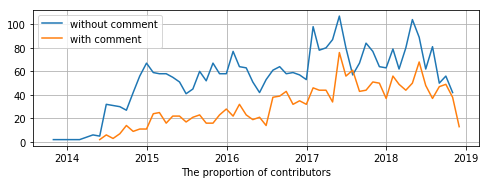

In [35]:
df_p2 = (
    comment_relation_all
    .assign(Occurred = lambda x: x['created_at']>x['comment_at'])
    .assign(Count = 1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'Occurred'])
    .sum()
    .reset_index()
)
plt.rcParams["figure.figsize"] = (8,2.5)
fig, ax = plt.subplots()

for type in df_p2.Occurred.unique():
    print(type)
    ax.plot(df_p2[lambda x: x['Occurred']==type]['created_at'],df_p2[lambda x: x['Occurred']==type]['Count'])
ax.set_xlabel('The proportion of contributors')
ax.set_ylabel('')
ax.legend(['without comment','with comment'],loc='upper left')
ax.grid(True)

This plot shows in our dataset the number of contributors with comment activity before start code activity is less than contributors without comment.

#### 2- Time interval between commenting activity and start contributing on a package.

In [36]:
comment_relation = (
    pull_commit_activity
    .merge(all_comments,how='inner',left_on=['Name','user_login'],right_on=['Name','user_login'])
    .assign(created_at = lambda x: pandas.to_datetime(x['created_at_x']))
    .assign(comment_at = lambda x: pandas.to_datetime(x['created_at_y']))
    .rename(columns={'author_assoc_x':'author_assoc','type_x':'type','author_assoc_y':'commenter_assoc','type_y':'cmt_type'})
    [['Name','user_login','created_at','author_assoc','type','commenter_assoc','comment_at','cmt_type']]
    [lambda x: x['created_at']>x['comment_at']]
)

##### 2-1- Monthly distribution

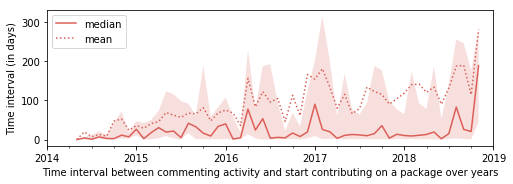

In [37]:
df_plot_interval = (
    comment_relation
    .assign(Interval = lambda x: (x['created_at'] - x['comment_at']).dt.total_seconds()/3600/24)
    .groupby([pandas.Grouper(key='created_at',freq='1M')])
    .describe()
    .xs('Interval', axis=1, drop_level=True)
    .reset_index()
    .set_index('created_at')
)

plt.rcParams["figure.figsize"] = (8,2.5)
fig, ax = plt.subplots()

df_plot_interval['50%'].rename('median').plot(color=palet, ax=ax)
df_plot_interval['mean'].plot(color=palet, style=':', ax=ax)
ax.fill_between(df_plot_interval.index, df_plot_interval['25%'], df_plot_interval['75%'], facecolor=palet[0], alpha=0.2)
ax.set(
    xlabel='Time interval between commenting activity and start contributing on a package over years',
    ylabel='Time interval (in days)',
    xlim=DATE_RANGE,
)
ax.legend(loc='upper left')

##### 2-2- Annual distribution

[Text(0.5, 0, 'Time inteval between start commenting on a package and start contributing in years')]

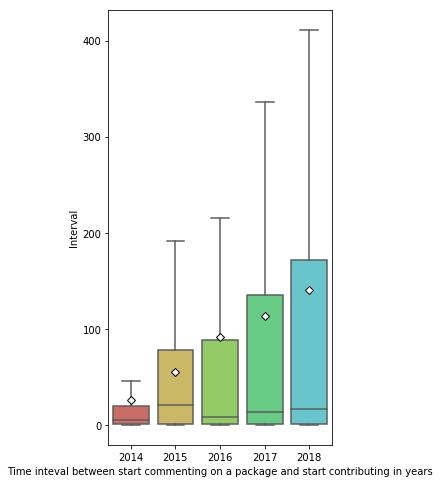

In [38]:
plt.rcParams["figure.figsize"] = (4,8)
fig, ax = plt.subplots()

seaborn.boxplot(
    x='Year', 
    y='Interval', 
    data=(
        comment_relation
        .assign(Interval = lambda x: (x['created_at'] - x['comment_at']).dt.total_seconds()/3600/24)
        .assign(Year = lambda x: x['created_at'].dt.year,axis=1)
        [['Year','Interval']]
    ),
    order=range(2014, 2019),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='Time inteval between start commenting on a package and start contributing in years', 
)

#### 3- Time interval between commenting activity and start contributing on a package according to comment type

This analysis can help us to understand how contributors behaviour changes regarding time interval between commenting activity and start contributing on a package and type of comments.

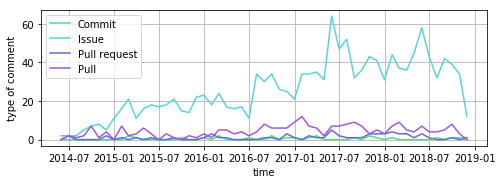

In [39]:
df_tmp = (
    comment_relation[['created_at','author_assoc','cmt_type']]
    .assign(count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'cmt_type'])
    .sum()
    .unstack('cmt_type')
    .fillna(0).rename(columns={'cmt': 'Commit',
                               'pul': 'Pull',
                               'isu': 'Issue',
                               'prq': 'Pull request'})
)
df_tmp = df_tmp.xs('count', axis=1, drop_level=True).reset_index()
plt.rcParams["figure.figsize"] = (8,2.5)
fig, ax = plt.subplots()


for i in range(1,len(df_tmp.columns)):
    ax.plot(df_tmp['created_at'],df_tmp[df_tmp.columns[i]],color= palet[i+2])
ax.set_xlabel('time')
ax.set_ylabel('Type of comment')
ax.grid(True)
ax.legend(('Commit','Issue','Pull request','Pull'))